# **PROJECT STATISTICAL MACHINE LEARNING**

## **📝 Import Library**

In [1]:
#Import Library
import argparse
import warnings
from typing import Dict , Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from tabulate import tabulate

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV  #Import CalibratedClassifierCV
from scipy.stats import randint, uniform
from itertools import product

#Untuk menonaktifkan pesan peringatan yang biasanya muncul
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
TARGET = "Attrition"
ID_COL = "id"

# ===== Library Advanced =====
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except Exception:
    LIGHTGBM_AVAILABLE = False

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

## **⚙️1. Data Loading**

In [2]:
print("\nSECTION 1: DATA LOADING")
print("-"*80)

# Load Dataset - Update the file paths to use the correct location in the Colab environment
train = pd.read_csv('C:/ITS/MATKUL/SEMESTER 5/SML/PRAKTIKUM SML/PROJECT SML/train.csv')
test = pd.read_csv('C:/ITS/MATKUL/SEMESTER 5/SML/PRAKTIKUM SML/PROJECT SML/test.csv')

print(f"Train: {train.shape}, Test: {test.shape}")

#Check Class Distribution
target_counts = train['Attrition'].value_counts()

print(f"\nClass 0: {target_counts[0]} ({target_counts[0]/len(train)*100:.1f}%)")
print(f"Class 1: {target_counts[1]} ({target_counts[1]/len(train)*100:.1f}%)")
print(f"Ratio: {target_counts[0]/target_counts[1]:.1f}:1")


SECTION 1: DATA LOADING
--------------------------------------------------------------------------------
Train: (1176, 36), Test: (294, 35)

Class 0: 986 (83.8%)
Class 1: 190 (16.2%)
Ratio: 5.2:1


## **🛠️ 2. Pre-Processing**

In [3]:
print("\nSECTION 2: PREPROCESSING")
print("-"*80)
#This section handles data cleaning and encoding before model training

# ---- Separate features and target variable ----
# Drop 'Attrition' and 'id' from training data, keep 'Attrition' as target
X = train.drop(['Attrition', 'id'], axis=1)
y = train['Attrition']

#Drop 'id' column from test data and store the IDs separately
X_test = test.drop(['id'], axis=1)
test_ids = test['id'].copy()

# ---- Remove constant columns ----
# Identify columns with only unique value (no variation) 
constant_cols = [col for col in X.columns if X[col].nunique() == 1]

if constant_cols:
    X = X.drop(constant_cols, axis=1)
    X_test = X_test.drop(constant_cols, axis=1)
    print(f"Removed: {constant_cols}")

# ---- Encode categorical variables ----
# Convert categorical (object-type) columns into numeric labels 
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))



SECTION 2: PREPROCESSING
--------------------------------------------------------------------------------
Removed: ['EmployeeCount', 'Over18', 'StandardHours']


## **📊Exploratory Data Analysis**

In [4]:
# 1. Numerical Descriptive Statistics
print("\n=== Numerical Descriptive Statistics ===")
# Display statistical summary for numerical columns (mean, std, min, max, quartiles)
print(train.describe().round(2))

# 2. Categorical Descriptive Statistics
print("\n=== Categorical Descriptive Statistics ===")
# Identify categorical columns (data type: object)
cat_cols = train.select_dtypes(include=['object']).columns

if len(cat_cols) > 0:
    # Loop through each categorical column and print category distribution in percentages
    for col in cat_cols:
        print(f"\nCategory Distribution for {col}:\n")
        print(train[col].value_counts(normalize=True).round(2) * 100)
else:
    print("No categorical columns found (all are numeric after preprocessing).")


# 3. Mean of Each Variable by Attrition Category
if 'Attrition' in train.columns:
    print("\n=== Mean of Each Variable by Attrition Category ===")
    # Compute mean values for each numeric column grouped by the 'Attrition' category
    mean_by_attrition = train.groupby('Attrition').mean(numeric_only=True).round(2)
    display(mean_by_attrition)
else:
    print("\nTarget column 'Attrition' not found in the training data.")


# 4. Missing Value Check
print("\n=== Missing Value Check (after preprocessing) ===")
# Count missing values in each column
missing_summary = train.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if not missing_summary.empty:
    print("Columns with missing values:\n", missing_summary)
else:
    print("No missing values found in the training data.")


# 5. Outlier Detection (based on IQR)
print("\n=== Outlier Detection (based on IQR) ===")

# Select only numeric columns
num_cols = train.select_dtypes(include=['number']).columns
outlier_summary = []

# Calculate IQR (Interquartile Range) and count outliers for each numeric variable
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((train[col] < lower) | (train[col] > upper)).sum()
    outlier_summary.append([col, outliers])

# Create a DataFrame for outlier summary
outlier_df = pd.DataFrame(outlier_summary, columns=['Variable', 'Number of Outliers'])

# Sort by the number of outliers (descending)
outlier_df = outlier_df.sort_values(by='Number of Outliers', ascending=False).reset_index(drop=True)

display(outlier_df)

# Display additional message about outliers
if outlier_df['Number of Outliers'].sum() == 0:
    print("No significant outliers detected using the IQR method.")
else:
    print("\nThe table above shows the number of outliers per numerical variable (sorted by count).")



=== Numerical Descriptive Statistics ===
           Age  DailyRate  DistanceFromHome  Education  EmployeeCount  \
count  1176.00    1176.00           1176.00    1176.00         1176.0   
mean     37.00     803.99              9.36       2.91            1.0   
std       9.18     401.34              8.18       1.03            0.0   
min      18.00     103.00              1.00       1.00            1.0   
25%      30.00     467.75              2.00       2.00            1.0   
50%      36.00     799.50              7.00       3.00            1.0   
75%      43.00    1157.00             14.00       4.00            1.0   
max      60.00    1499.00             29.00       5.00            1.0   

       EmployeeNumber  EnvironmentSatisfaction  HourlyRate  JobInvolvement  \
count         1176.00                  1176.00     1176.00         1176.00   
mean          1015.83                     2.72       65.50            2.74   
std            599.66                     1.09       20.37        

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,,,
0,37.74,816.56,9.05,2.92,1.0,1009.80,2.77,65.67,2.78,2.16,...,2.76,80.0,0.84,12.00,2.78,2.78,7.46,4.49,2.24,4.46
1,33.13,738.74,10.97,2.84,1.0,1047.15,2.44,64.60,2.54,1.66,...,2.63,80.0,0.52,8.06,2.65,2.63,4.90,2.87,1.87,2.83



=== Missing Value Check (after preprocessing) ===
No missing values found in the training data.

=== Outlier Detection (based on IQR) ===


,Variable,Number of Outliers
0,Attrition,190
1,PerformanceRating,185
2,TrainingTimesLastYear,174
3,MonthlyIncome,86
4,YearsSinceLastPromotion,85
5,StockOptionLevel,66
6,TotalWorkingYears,52
7,YearsAtCompany,52
8,NumCompaniesWorked,36
9,YearsInCurrentRole,16



The table above shows the number of outliers per numerical variable (sorted by count).


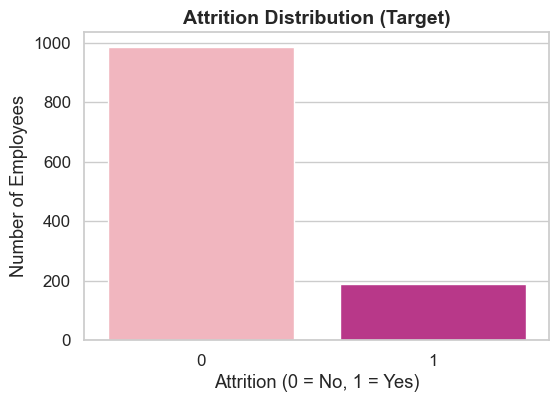


Visualizing numerical feature distributions...


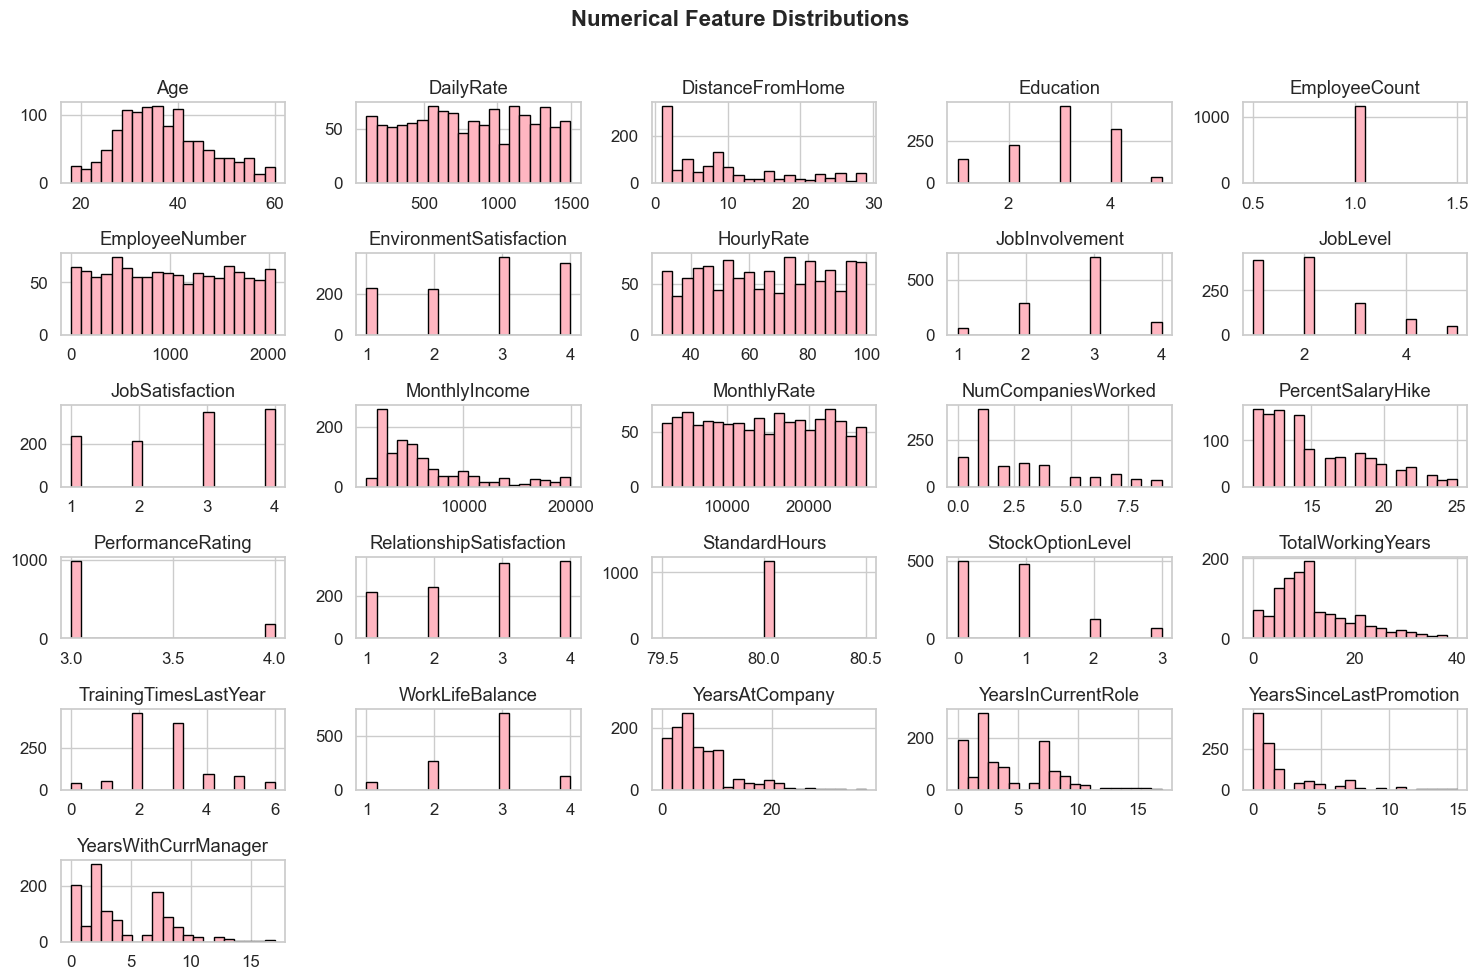


Visualizing categorical feature distributions...


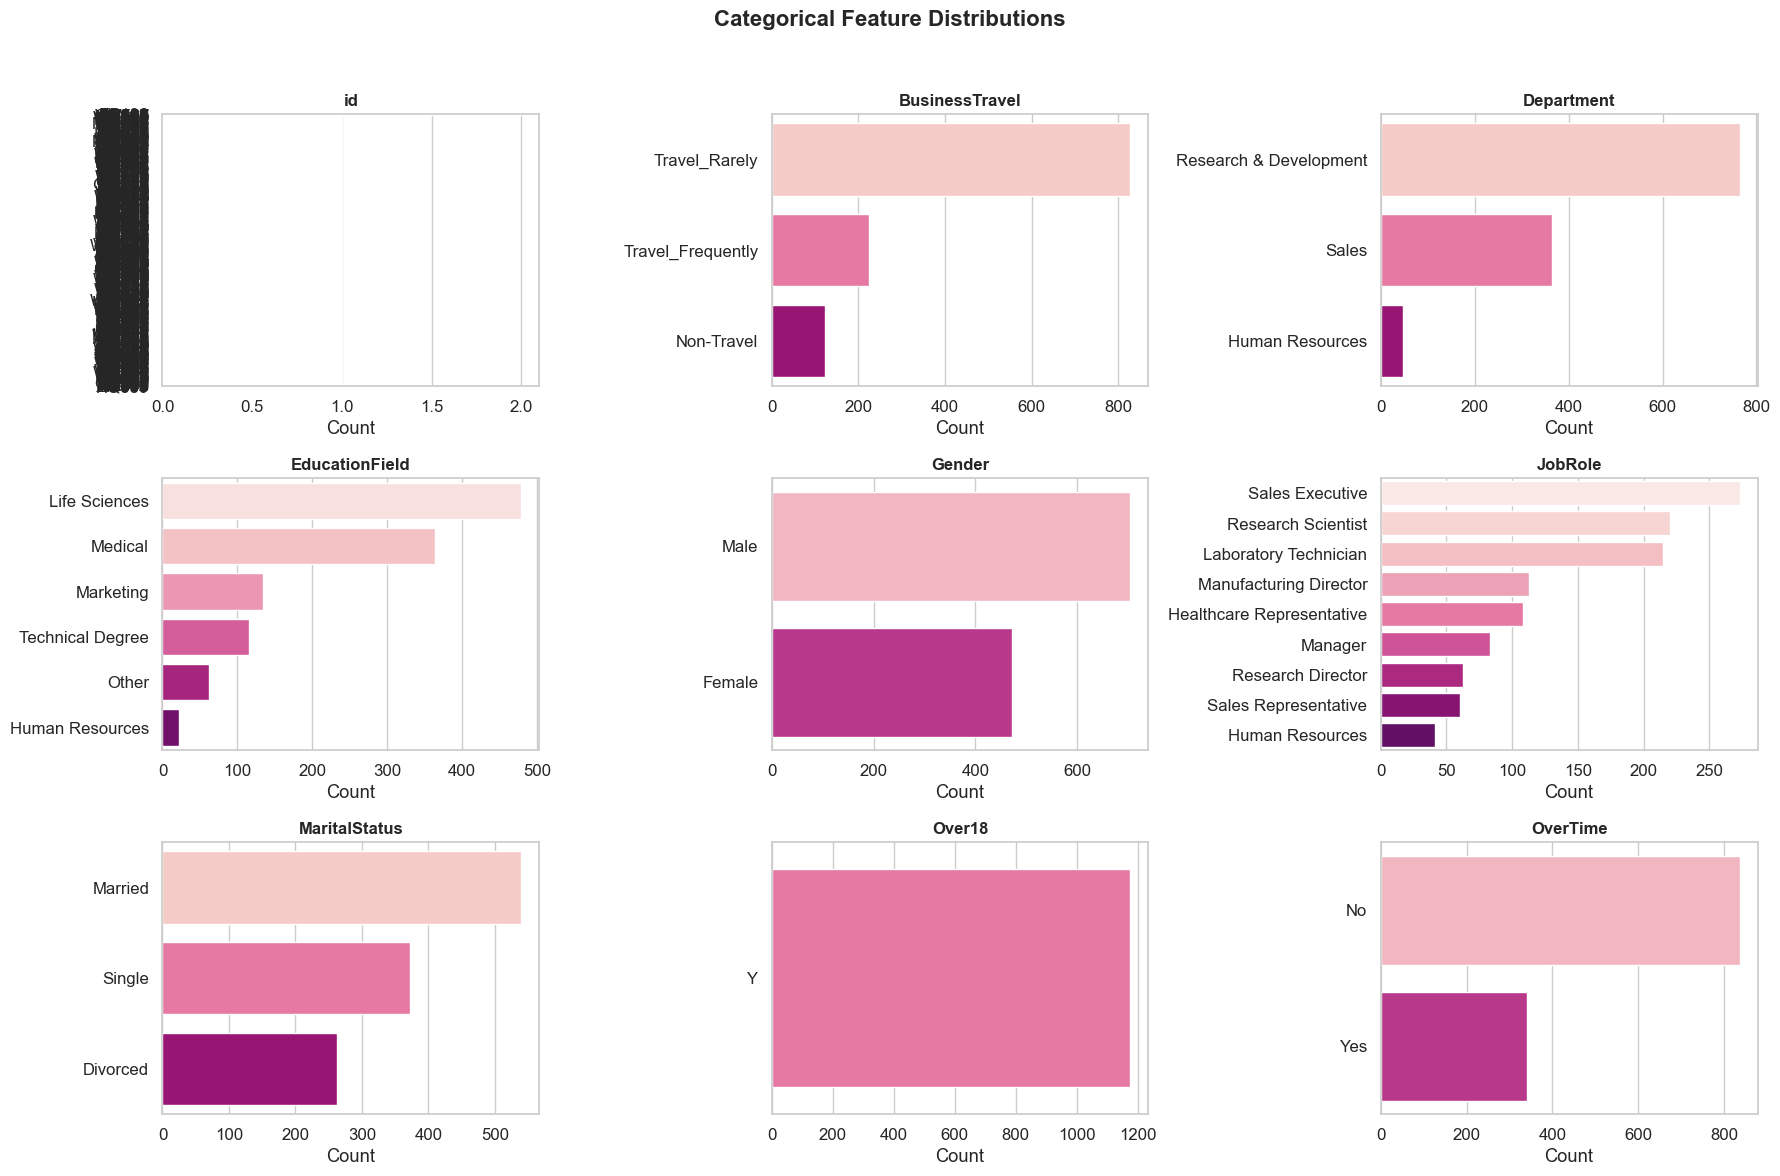

In [6]:
# Visualization Setup
sns.set(style="whitegrid", palette="RdPu", font_scale=1.1)
plt.rcParams['figure.figsize'] = [10, 5]


# 1. Target Variable Distribution: Attrition
if 'Attrition' in train.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Attrition', data=train, palette='RdPu')
    plt.title('Attrition Distribution (Target)', fontsize=14, fontweight='bold')
    plt.xlabel('Attrition (0 = No, 1 = Yes)')
    plt.ylabel('Number of Employees')
    plt.show()
else:
    print("Column 'Attrition' not found in the training dataset — skipping target visualization.")


# 2. Distribution of Numerical Features
print("\nVisualizing numerical feature distributions...")

# Select all numeric columns except the target variable 'Attrition'
num_cols = train.select_dtypes(include=['number']).columns.drop('Attrition', errors='ignore')

if len(num_cols) > 0:
    train[num_cols].hist(
        bins=20,
        figsize=(15, 10),
        color='lightpink',
        edgecolor='black'
    )
    plt.suptitle('Numerical Feature Distributions', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
else:
    print("No numeric features available for visualization.")


# 3. Distribution of Categorical Features
print("\nVisualizing categorical feature distributions...")

# Select categorical columns
cat_cols = train.select_dtypes(include=['object']).columns

if len(cat_cols) > 0:
    n_cols = 3  # Number of subplot columns per row
    n_rows = int(np.ceil(len(cat_cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten()

    # Create a countplot for each categorical column
    for i, col in enumerate(cat_cols):
        sns.countplot(
            y=col,
            data=train,
            order=train[col].value_counts().index,
            palette='RdPu',
            ax=axes[i]
        )
        axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel('')

    # Remove unused subplots (if fewer categorical columns than subplots)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Categorical Feature Distributions', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No categorical columns found (all features are numeric after preprocessing).")



=== Correlation Among Numerical Features ===
⚠️ Constant columns removed before correlation: ['EmployeeCount', 'StandardHours']


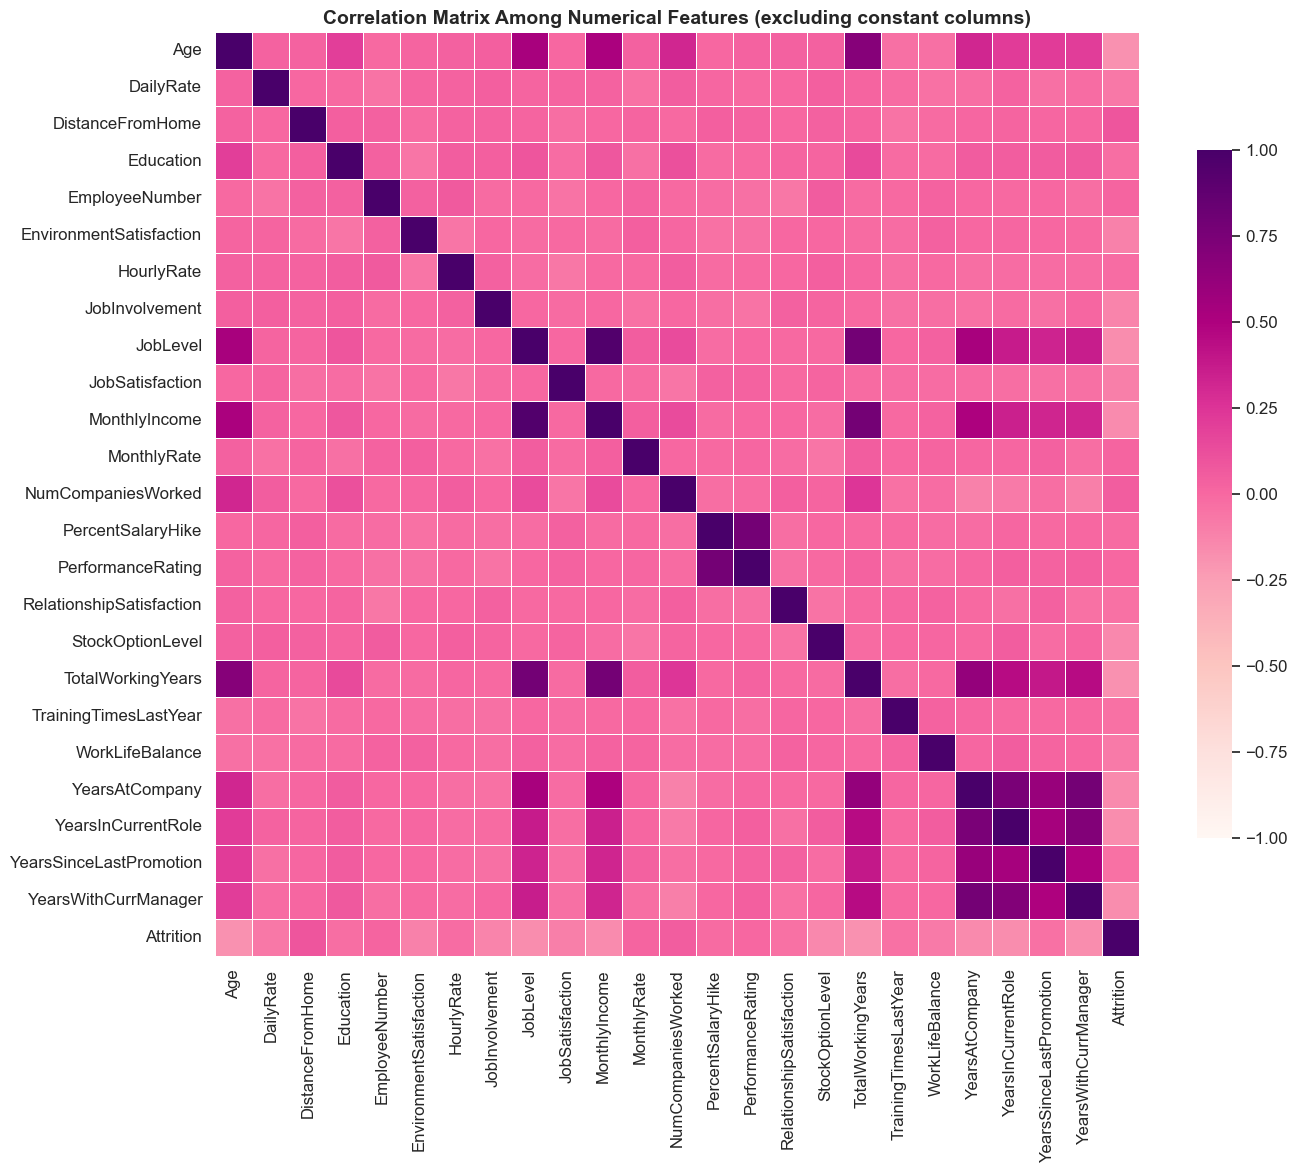


=== Distribution of Numerical Features by Attrition ===


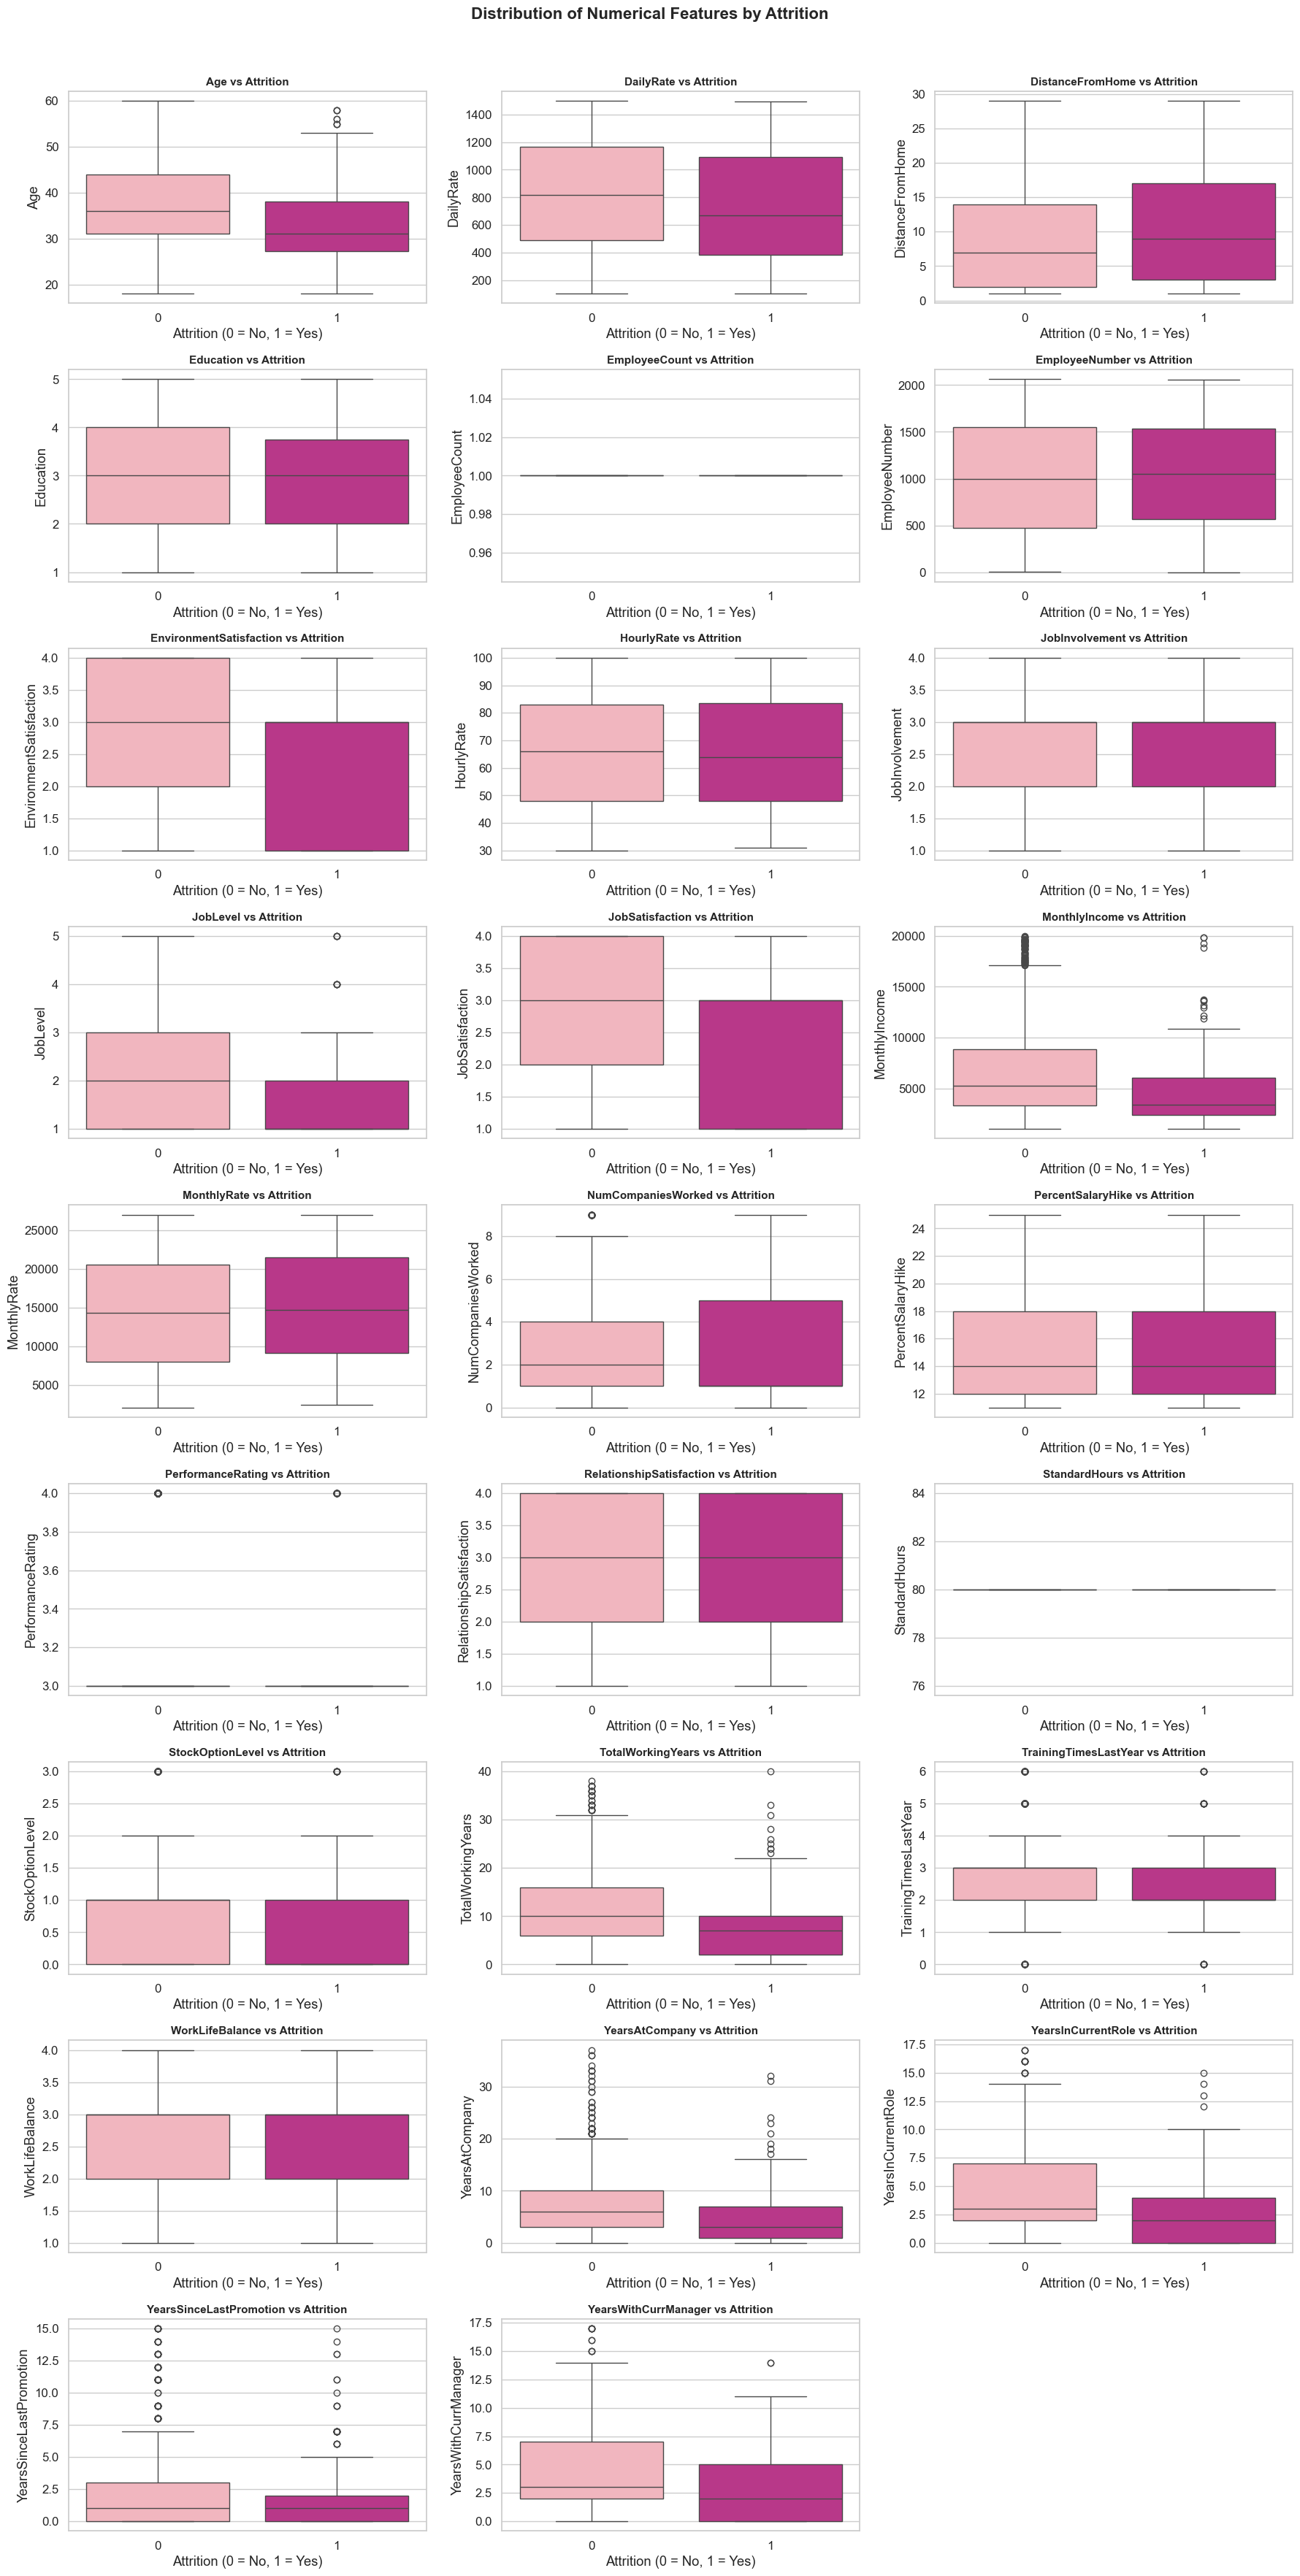

In [9]:
# 1. Correlation Matrix Among Numerical Features
print("\n=== Correlation Among Numerical Features ===")

# Select only numerical columns
num_cols = train.select_dtypes(include=['number']).columns

# Ensure there are at least two numerical columns to compute correlation
if len(num_cols) > 1:
    # Identify constant columns (with only one unique value)
    constant_cols = [col for col in num_cols if train[col].nunique() == 1]
    if constant_cols:
        print(f"⚠️ Constant columns removed before correlation: {constant_cols}")
        num_cols = [col for col in num_cols if col not in constant_cols]

    # Compute correlation matrix (pairwise to avoid NaN-related issues)
    corr = train[num_cols].corr(method='pearson', numeric_only=True)

    # Check if correlation matrix contains any NaN values
    if corr.isna().sum().sum() > 0:
        print("⚠️ NaN values detected in correlation matrix — some columns may not be valid for correlation calculation.")

    # Plot correlation heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        corr,
        cmap='RdPu',
        center=0,
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        linecolor='white',
        square=True,
        cbar_kws={'shrink': 0.7}
    )
    plt.title('Correlation Matrix Among Numerical Features (excluding constant columns)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

else:
    print("Not enough numerical columns to compute correlation.")


# 2. Distribution of Numerical Features by Attrition
print("\n=== Distribution of Numerical Features by Attrition ===")

# Select numeric columns excluding the target variable 'Attrition'
num_cols = train.select_dtypes(include=['number']).columns.drop('Attrition', errors='ignore')

if len(num_cols) > 0:
    n_cols = 3  # Number of subplot columns per row
    n_rows = int(np.ceil(len(num_cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten()

    # Create boxplots to compare each numeric variable with Attrition
    for i, col in enumerate(num_cols):
        sns.boxplot(
            data=train,
            x='Attrition',
            y=col,
            palette='RdPu',
            ax=axes[i]
        )
        axes[i].set_title(f'{col} vs Attrition', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Attrition (0 = No, 1 = Yes)')
        axes[i].set_ylabel(col)

    # Remove unused subplots (if fewer numeric columns than subplot slots)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Distribution of Numerical Features by Attrition', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
else:
    print("No numerical columns available for visualization.")


## **⚓3. Feature Engineering**

In [10]:
print("\nSECTION 3: FEATURE ENGINEERING")
print("-"*80)
#This section creates new engineered features to better capture

def create_features(df):
    df = df.copy()

    # 1) Core Ratio Features
    df['ExperienceRatio'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1)
    df['CurrentRoleRatio'] = df['YearsInCurrentRole'] / (df['YearsAtCompany'] + 1)
    df['JobHoppingRate'] = df['NumCompaniesWorked'] / (df['TotalWorkingYears'] + 1)
    df['ManagerStability'] = df['YearsWithCurrManager'] / (df['YearsAtCompany'] + 1)

    # 2) Binary Indicators
    df['IsYoung'] = (df['Age'] < 30).astype(int)
    df['TimeWithoutPromotion'] = (df['YearsSinceLastPromotion'] > 3).astype(int)
    df['LowJobLevel'] = (df['JobLevel'] <= 1).astype(int)
    df['LongCommute'] = (df['DistanceFromHome'] > 15).astype(int)
    df['PoorWorkLife'] = (df['WorkLifeBalance'] <= 2).astype(int)
    df['OverTime_Binary'] = df['OverTime']

    # 3) Satisfaction & Career Dynamics
    satisfaction_cols = [
        'EnvironmentSatisfaction', 'JobSatisfaction',
        'RelationshipSatisfaction', 'WorkLifeBalance'
    ]
    df['AvgSatisfaction'] = df[satisfaction_cols].mean(axis=1)
    df['LowSatisfaction'] = (df['AvgSatisfaction'] < 2).astype(int)
    df['Career_Stagnation'] = (
        (df['YearsSinceLastPromotion'] > 5) & (df['YearsAtCompany'] > 10)
    ).astype(int)

    # 4) Combined Risk Score
    df['AttritionRiskScore'] = (
        df['LowSatisfaction'] * 2.5 +
        df['OverTime_Binary'] * 2.0 +
        df['LongCommute'] * 1.0 +
        df['TimeWithoutPromotion'] * 2.0 +
        df['PoorWorkLife'] * 1.5 +
        df['LowJobLevel'] * 0.5 +
        df['Career_Stagnation'] * 2.0 +
        df['JobHoppingRate'] * 10
    )

    # 5) Extended Features (optional)
    df['IncomePerYear'] = df['MonthlyIncome'] / (df['TotalWorkingYears'] + 1)
    df['Income_JobLevel'] = df['MonthlyIncome'] * df['JobLevel']
    df['Age_Experience'] = df['Age'] * df['TotalWorkingYears']
    df['Satisfaction_Performance'] = df['AvgSatisfaction'] * df['PerformanceRating']
    df['Seniority'] = df['JobLevel'] * df['TotalWorkingYears']
    df['Promotion_Rate'] = df['YearsAtCompany'] / (df['YearsSinceLastPromotion'] + 1)

    return df

# Apply feature creation to train and test sets
X_eng = create_features(X)
X_test_eng = create_features(X_test)

print(f"Features: {X.shape[1]} -> {X_eng.shape[1]}"); 


SECTION 3: FEATURE ENGINEERING
--------------------------------------------------------------------------------
Features: 31 -> 51


## **🔍4. Feature Selection**

In [11]:
print("\nSECTION 4: FEATURE SELECTION")
print("-"*80)
#This section uses a Random Forest model to evaluate feature importance and save the visualization as an image file instead of displaying it.

# 1) Train Random Forest model to get feature importances
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_eng, y)

# 2️) Create a DataFrame of features and their importances
feat_imp = (
    pd.DataFrame({
    'feature': X_eng.columns,
    'importance': rf.feature_importances_
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

# 3️) Print Top 20 Most Important Features
print("\n ===== Top 20 Fitur Terpenting =====")
for i, (f, imp) in enumerate(zip(feat_imp['feature'][:20], feat_imp['importance'][:20]), 1):
    print(f"{i:2d}. {f.ljust(35)} {imp:>10.6f}")

# 4️) Select top features (Max 60 Variable)
N_FEAT = min(60, len(feat_imp))
selected = feat_imp.head(N_FEAT)['feature'].tolist()

# Save Datasets with Selected Features
X_sel = X_eng[selected].copy()
X_test_sel = X_test_eng[selected].copy()

print(f"\n=====Selected Top {N_FEAT} features:=====")
print(selected[:10], "..." if len(selected) > 10 else "")
print(f"\nFinal shape -> X_sel: {X_sel.shape}, X_test_sel: {X_test_sel.shape}")

# 5️) Visualize and save feature importance chart (no display)
fig, ax = plt.subplots(figsize=(12, 10))
top = feat_imp.head(30)
ax.barh(top['feature'], top['importance'], color='lightpink')
ax.set_xlabel('Importance', fontsize=11)
ax.set_ylabel('Feature', fontsize=11)
ax.set_title('Feature Importances', fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()

# Save to file
output_path = "feature_importance.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"\nFeature importance chart saved as '{output_path}' ✅\n")



SECTION 4: FEATURE SELECTION
--------------------------------------------------------------------------------

 ===== Top 20 Fitur Terpenting =====
 1. AttritionRiskScore                    0.077714
 2. Age_Experience                        0.059433
 3. Income_JobLevel                       0.044588
 4. Age                                   0.042031
 5. MonthlyIncome                         0.041789
 6. JobHoppingRate                        0.040061
 7. Seniority                             0.032116
 8. IncomePerYear                         0.030065
 9. TotalWorkingYears                     0.028681
10. HourlyRate                            0.028677
11. DailyRate                             0.028454
12. DistanceFromHome                      0.028162
13. AvgSatisfaction                       0.027116
14. EmployeeNumber                        0.025803
15. MonthlyRate                           0.025095
16. OverTime_Binary                       0.024646
17. Satisfaction_Performance       

## **🕹️5. Split Data Training and Data Validation**

In [12]:
print("\nSECTION 5: TRAIN–VAL SPLIT")
print("-"*80)

# 1️) S plit data (80:20) with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_sel, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

# 2️) Check target distribution in train and validation sets
print("\n===== Distribusi Target (setelah stratify): =====")
train_dist = y_train.value_counts(normalize=True).round(3)
val_dist = y_val.value_counts(normalize=True).round(3)

print("Train set:")
print(train_dist)
print("\nValidation set:")
print(val_dist)

# 3️) Feature scaling using MinMaxScaler
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)

print("\nData scaling completed successfully ✅\n")


SECTION 5: TRAIN–VAL SPLIT
--------------------------------------------------------------------------------
Train: (940, 51), Val: (236, 51)

===== Distribusi Target (setelah stratify): =====
Train set:
Attrition
0    0.838
1    0.162
Name: proportion, dtype: float64

Validation set:
Attrition
0    0.839
1    0.161
Name: proportion, dtype: float64

Data scaling completed successfully ✅



## **🏛️6. Class Balancing and HyperParameter Tunning**

In [13]:
print("\nSECTION 6 : CLASS BALANCING AND HYPERPARAMETER TUNNING")
print("-" * 80)
#This section handles dataset balancing using SMOTE (Optional) and performs hyperprameter tuning for LightGBM and XBoost Models

print("\n SECTION 6A : CLASS BLANCING")
print("-" * 80) 

# You can toggle this flag if you want to try SMOTE
USE_SMOTE = False  # default : not use SMOTE
IMBLEARN_AVAILABLE = True # ENsure imbalanced-learn is available

if IMBLEARN_AVAILABLE and USE_SMOTE:
    # 1) Combine SMOTE and RandomUnderSampler
    smote = SMOTE(sampling_strategy=0.3, random_state=42, k_neighbors=3)
    under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

    # 2) Oversampling followed by undersampling
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    X_train_bal, y_train_bal = under.fit_resample(X_train_bal, y_train_bal)

    # 3) Re-scale data since SMOTE introduces new samples
    X_train_bal_sc = scaler.fit_transform(X_train_bal)

    print(f"Balanced: {X_train.shape[0]} → {X_train_bal.shape[0]} samples")
    print("Distribusi label setelah balancing:")
    print(pd.Series(y_train_bal).value_counts(normalize=True).round(3))

    # 4) Visualize class distribution before and after balancing
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    colors = ["skyblue", "hotpink"]

    # Before balancing
    axes[0].bar(['No', 'Yes'], y_train.value_counts().sort_index(), color=colors)
    axes[0].set_title('Original', fontweight='bold')
    axes[0].set_ylabel('Count')

    # After balancing
    axes[1].bar(['No', 'Yes'], pd.Series(y_train_bal).value_counts().sort_index(), color=colors)
    axes[1].set_title('After SMOTE + UnderSampling', fontweight='bold')

    plt.tight_layout()
    plt.savefig('balancing.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

else:
    # Without SMOTE — use original data with class_weight in model training
    X_train_bal, y_train_bal = X_train.copy(), y_train.copy()
    X_train_bal_sc = X_train_sc.copy()
    print("Not using SMOTE — original data will be trained with class_weight balancing")


print("\nSECTION 6B: HYPERPARAMETER TUNING (Fast + Smart)")
print("-"*80)

#Setup Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ===== Tuning LightGBM (FAST) =====
print("\n♦ Tuning LightGBM Hyperparameters (Fast Mode)...")

param_dist_lgb = {
    'num_leaves': randint(25, 45), 'learning_rate': uniform(0.01, 0.03),
    'n_estimators': randint(400, 900), 'min_child_samples': randint(25, 55),
    'subsample': uniform(0.7, 0.3), 'colsample_bytree': uniform(0.7, 0.3),
    'reg_lambda': uniform(1, 6), 'reg_alpha': uniform(0, 3),
    'max_depth': [-1, 4, 5, 6]
}

lgb_base = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
search_lgb = RandomizedSearchCV(
    estimator=lgb_base, param_distributions=param_dist_lgb,
    n_iter=10, scoring='roc_auc', cv=cv,
    random_state=42, n_jobs=-1, verbose=1
)

search_lgb.fit(X_train_bal, y_train_bal)
print(f"\n✅ Best LightGBM Params:\n{search_lgb.best_params_}")
print(f"Best CV AUC: {search_lgb.best_score_:.4f}")
best_lgb_params = search_lgb.best_params_

# ===== Tuning XGBoost (FAST) =====
try:
    print("\n♦ Tuning XGBoost Hyperparameters (Fast Mode)...")

    param_dist_xgb = {
        'max_depth': randint(3, 6), 'learning_rate': uniform(0.01, 0.05),
        'n_estimators': randint(400, 800), 'min_child_weight': randint(2, 8),
        'subsample': uniform(0.7, 0.3), 'colsample_bytree': uniform(0.7, 0.3),
        'gamma': uniform(0, 2), 'reg_alpha': uniform(0, 3), 'reg_lambda': uniform(1, 8)
    }

    xgb_base = XGBClassifier(
        eval_metric='auc', random_state=42, n_jobs=-1, use_label_encoder=False,
    )

    search_xgb = RandomizedSearchCV(
        estimator=xgb_base, param_distributions=param_dist_xgb,
        n_iter=10, scoring='roc_auc', cv=cv,
        random_state=42, n_jobs=-1, verbose=1
    )
    search_xgb.fit(X_train_bal, y_train_bal)
    print(f"\n✅ Best XGBoost Params:\n{search_xgb.best_params_}")
    print(f"Best CV AUC: {search_xgb.best_score_:.4f}")
    best_xgb_params = search_xgb.best_params_


except Exception as e:
    print(f"\n Skipping XGBoost tuning (error or not installed): {e}")

print("\n🎯 DONE: Class balancing and hyperparameter tuning completed successfully!")


SECTION 6 : CLASS BALANCING AND HYPERPARAMETER TUNNING
--------------------------------------------------------------------------------

 SECTION 6A : CLASS BLANCING
--------------------------------------------------------------------------------
Not using SMOTE — original data will be trained with class_weight balancing

SECTION 6B: HYPERPARAMETER TUNING (Fast + Smart)
--------------------------------------------------------------------------------

♦ Tuning LightGBM Hyperparameters (Fast Mode)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best LightGBM Params:
{'colsample_bytree': np.float64(0.9976634677873653), 'learning_rate': np.float64(0.028524445288831496), 'max_depth': 4, 'min_child_samples': 46, 'n_estimators': 652, 'num_leaves': 36, 'reg_alpha': np.float64(0.06918727512424727), 'reg_lambda': np.float64(4.148647961550335), 'subsample': np.float64(0.8199582915145766)}
Best CV AUC: 0.8220

♦ Tuning XGBoost Hyperparameters (Fast Mode)...
Fitting 3 folds for 

## **🏃🏻‍♀️7. MODEL TRAINING**

In [14]:
print("\nSECTION 7: MODEL TRAINING (TUNED & Optimized)")
print("-" * 80)
# This section trains multiple ML models using optimized parameters and evaluates performance consistency through ROC-AUC metrics

results = {}

# 10-Fold CV for more stable evaluation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def train_model(name, model, use_scaled=False):

    print(f"\nTraining {name}...")

    X_tr = X_train_bal_sc if use_scaled else X_train_bal
    y_tr = y_train_bal
    X_v = X_val_sc if use_scaled else X_val

    model.fit(X_tr, y_tr)
    y_tr_pred = model.predict_proba(X_tr)[:, 1]
    y_v_pred = model.predict_proba(X_v)[:, 1]

    tr_score = roc_auc_score(y_tr, y_tr_pred)
    v_score = roc_auc_score(y_val, y_v_pred)

    try:
        cv_scores = cross_val_score(model, X_tr, y_tr, cv=cv, scoring="roc_auc", n_jobs=-1)
        cv_mean, cv_std = cv_scores.mean(), cv_scores.std()
    except Exception as e:
        print(f"CV error for {name}: {e}")
        cv_mean, cv_std = v_score, 0.0

    gap = tr_score - v_score
    status = "GOOD" if gap < 0.05 else "WARN" if gap < 0.10 else "BAD"

    print(f" Train: {tr_score:.4f}, Val: {v_score:.4f}, CV: {cv_mean:.4f}, Gap: {gap:.4f} ({status})")

    results[name] = {
        "model": model,
        "train": tr_score,
        "val": v_score,
        "cv": cv_mean,
        "cv_std": cv_std,
        "gap": gap,
        "pred": y_v_pred,
        "scaled": use_scaled,
    }

# ========================= LINEAR MODELS =========================
print("\n====== LINEAR MODELS (Regularized) ======")

train_model("Logistic L2 (Tuned)",
    LogisticRegression(max_iter=5000, C=0.05, penalty="l2", solver="lbfgs",
                       class_weight="balanced", random_state=42), True)

train_model("Logistic L1 (Tuned)",
    LogisticRegression(max_iter=5000, C=0.02, penalty="l1", solver="saga",
                       class_weight="balanced", random_state=42), True)

# ========================= TREE MODELS =========================
print("\n===== TREE MODELS (Tuned for Generalization) =====")

train_model("Random Forest (Optimized)",
    RandomForestClassifier(n_estimators=500, max_depth=6, min_samples_split=40,
                           min_samples_leaf=20, max_features="sqrt", max_samples=0.8,
                           bootstrap=True, class_weight="balanced",
                           random_state=42, n_jobs=-1), False)

train_model("Extra Trees (Optimized)",
    ExtraTreesClassifier(n_estimators=700, max_depth=7, min_samples_split=25,
                         min_samples_leaf=12, max_features="sqrt",
                         class_weight="balanced", random_state=42, n_jobs=-1), False)

train_model("Gradient Boosting (Optimized)",
    GradientBoostingClassifier(n_estimators=1200, learning_rate=0.01,
                               max_depth=3, min_samples_split=30, min_samples_leaf=15,
                               subsample=0.75, max_features="sqrt",
                               random_state=42), False)

if XGBOOST_AVAILABLE:
    train_model("XGBoost (Optimized)",
        XGBClassifier(n_estimators=1200, learning_rate=0.015, max_depth=4,
                      min_child_weight=8, subsample=0.8, colsample_bytree=0.8,
                      reg_alpha=5.0, reg_lambda=25.0, gamma=1.0,
                      eval_metric="auc", random_state=42, n_jobs=-1), False)

if LIGHTGBM_AVAILABLE:
    train_model("LightGBM (Tuned)",
        LGBMClassifier(n_estimators=1800, learning_rate=best_lgb_params["learning_rate"],
                       num_leaves=best_lgb_params["num_leaves"],
                       min_child_samples=best_lgb_params["min_child_samples"],
                       subsample=best_lgb_params["subsample"],
                       colsample_bytree=best_lgb_params["colsample_bytree"],
                       reg_alpha=3.0, reg_lambda=6.0,
                       random_state=42, verbose=-1), False)
    
if CATBOOST_AVAILABLE:
    train_model("CatBoost (Optimized)",
        CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=4,
                           l2_leaf_reg=10.0, subsample=0.7,
                           random_state=42, verbose=False), False)
    
# ========================= EXPERIMENTAL MODELS =========================
print("\n====== EXPERIMENTAL MODELS (New) ======")

train_model("AdaBoost (Tuned)",
    AdaBoostClassifier(n_estimators=500, learning_rate=0.02,
                       random_state=42), False)

train_model("HistGradientBoosting (Fast)",
    HistGradientBoostingClassifier(learning_rate=0.03, l2_regularization=1.0,
                                   max_iter=800, max_depth=4, random_state=42), False)

train_model("Bagging (Logistic Base)",
    BaggingClassifier(estimator=LogisticRegression(max_iter=3000, C=0.05, solver="lbfgs"),
                      n_estimators=60, random_state=42, n_jobs=-1), True)


SECTION 7: MODEL TRAINING (TUNED & Optimized)
--------------------------------------------------------------------------------

====== LINEAR MODELS (Regularized) ======

Training Logistic L2 (Tuned)...
 Train: 0.8496, Val: 0.8321, CV: 0.8144, Gap: 0.0175 (GOOD)

Training Logistic L1 (Tuned)...
 Train: 0.6921, Val: 0.7275, CV: 0.6387, Gap: -0.0354 (GOOD)

===== TREE MODELS (Tuned for Generalization) =====

Training Random Forest (Optimized)...
 Train: 0.9187, Val: 0.7919, CV: 0.7858, Gap: 0.1269 (BAD)

Training Extra Trees (Optimized)...
 Train: 0.9472, Val: 0.8215, CV: 0.8005, Gap: 0.1256 (BAD)

Training Gradient Boosting (Optimized)...
 Train: 0.9905, Val: 0.8008, CV: 0.8238, Gap: 0.1898 (BAD)

Training XGBoost (Optimized)...
 Train: 0.8963, Val: 0.8091, CV: 0.8156, Gap: 0.0871 (WARN)

Training LightGBM (Tuned)...
 Train: 0.9958, Val: 0.7872, CV: 0.8169, Gap: 0.2086 (BAD)

Training CatBoost (Optimized)...
 Train: 0.9670, Val: 0.8121, CV: 0.8225, Gap: 0.1550 (BAD)

====== EXPERIMENTA

## **👓 8.MODEL COMPARISON**

In [15]:
print("\n\nSECTION 8: COMPARISON")
print("-"*80)
#This section summarizes and visualizes all model performances using ROC-AUC metrics for train, vaidation, and CV Scores

# --- Convert results dictionary to DataFrame ---
df_res = (
    pd.DataFrame({
        "Model": list(results.keys()),
        "Train": [v["train"] for v in results.values()],
        "Val": [v["val"] for v in results.values()],
        "CV": [v["cv"] for v in results.values()],
        "Gap": [v["gap"] for v in results.values()]
    })
    .sort_values("CV", ascending=False)
    .reset_index(drop=True)
)

# --- Display Summary ---
print("\n" + df_res.to_string(index=False))
print(f"\nBest CV: {df_res['CV'].max():.4f}, Best Val: {df_res['Val'].max():.4f}")

# --- Create Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot 1 : Cross Validation AUC Scores
ax = axes[0, 0]
sorted_df = df_res.sort_values("CV")
colors = ["skyblue" if x < 0.05 else "hotpink" if x < 0.10 else "purple" for x in sorted_df["Gap"]]
ax.barh(range(len(sorted_df)), sorted_df["CV"], color=colors)
ax.set_yticks(range(len(sorted_df)))
ax.set_yticklabels(sorted_df["Model"], fontsize=9)
ax.set_xlabel("CV ROC-AUC", fontsize=10)
ax.set_title("Cross-Validation Scores", fontweight="bold")

# Plot 2 : Train vs Validation AUC
ax = axes[0, 1]
x = np.arange(len(df_res)); w = 0.35
ax.bar(x - w/2, df_res["Train"], width=w, label="Train", color="pink")
ax.bar(x + w/2, df_res["Val"], width=w, label="Validation", color="hotpink")
ax.set_xticks(x); ax.set_xticklabels(df_res["Model"], rotation=45, ha="right", fontsize=8)
ax.set_title("Train vs Validation ROC-AUC", fontweight="bold")
ax.legend()

# Plot 3 : Overfitting Grup
ax = axes[1, 0]
colors = ["skyblue" if x < 0.05 else "hotpink" if x < 0.10 else "purple" for x in sorted_df["Gap"]]
ax.barh(range(len(df_res)), df_res["Gap"], color=colors)
ax.set_yticks(range(len(df_res)))
ax.set_yticklabels(df_res["Model"], fontsize=9)
ax.axvline(x=0.05, color="orange", linestyle="--", label="Mild Overfit")
ax.axvline(x=0.10, color="red", linestyle="--", label="Strong Overfit")
ax.legend(fontsize=8)
ax.set_xlabel("Train-Val Gap")
ax.set_title("Overfitting Gap Analysis", fontweight="bold")

# Plot 4 : Generalization Plot (Gap vs CV)
ax = axes[1, 1]
ax.scatter(df_res["Gap"], df_res["CV"], s=100, alpha=0.7, color="blue")
for _, row in df_res.iterrows():
    ax.annotate(row["Model"], (row["Gap"], row["CV"]), fontsize=8, ha="right")
ax.set_xlabel("Train–Val Gap", fontsize=10)
ax.set_ylabel("CV ROC-AUC", fontsize=10)
ax.set_title("Generalization Scatter Plot", fontweight="bold")
ax.grid(True, alpha=0.3)

#--- Save Visualization ---
plt.tight_layout()
plt.savefig('comparison.png', dpi=300, bbox_inches='tight')
plt.close()



SECTION 8: COMPARISON
--------------------------------------------------------------------------------

                        Model    Train      Val       CV       Gap
Gradient Boosting (Optimized) 0.990532 0.800771 0.823761  0.189761
         CatBoost (Optimized) 0.967022 0.812068 0.822537  0.154954
             LightGBM (Tuned) 0.995817 0.787214 0.816926  0.208603
          XGBoost (Optimized) 0.896273 0.809144 0.815625  0.087129
          Logistic L2 (Tuned) 0.849628 0.832137 0.814378  0.017490
      Bagging (Logistic Base) 0.836511 0.834530 0.811003  0.001982
      Extra Trees (Optimized) 0.947151 0.821505 0.800464  0.125647
  HistGradientBoosting (Fast) 1.000000 0.764753 0.799087  0.235247
             AdaBoost (Tuned) 0.856215 0.783360 0.792461  0.072855
    Random Forest (Optimized) 0.918740 0.791866 0.785804  0.126874
          Logistic L1 (Tuned) 0.692109 0.727539 0.638655 -0.035430

Best CV: 0.8238, Best Val: 0.8345


## **⚖️ 9. CALIBRATION**

In [16]:
print("\n\nSECTION 9: CALIBRATION")
print("="*80)

# --- Select Top 3 Models by CV Score ---
top3 = top3 = df_res.nlargest(3, 'CV')['Model'].tolist()
print(f"Calibrating: {top3}")

# --- Perform Calibration using Isotonic Regression ---
calib = {}

for name in top3:
    print(f"\n{name}...")

    r = results[name]
    X_tr = X_train_bal_sc if (r['scaled'] and IMBLEARN_AVAILABLE) else X_train_sc if r['scaled'] else X_train_bal if IMBLEARN_AVAILABLE else X_train
    y_tr = y_train_bal if IMBLEARN_AVAILABLE else y_train
    X_v = X_val_sc if r['scaled'] else X_val

    # Initialize and fit calibrated model
    clf = CalibratedClassifierCV(r['model'], method='isotonic', cv=3)
    clf.fit(X_tr, y_tr)
    
    # Predict probabilities and evaluate ROC-AUC
    pred = clf.predict_proba(X_v)[:, 1]
    score = roc_auc_score(y_val, pred)

    print(f"  Original: {r['val']:.4f}, Calibrated: {score:.4f}, Gain: {score - r['val']:+.4f}")

    calib[f"{name} (Cal)"] = {'model': clf, 'val': score, 'pred': pred, 'scaled': r['scaled']}



SECTION 9: CALIBRATION
Calibrating: ['Gradient Boosting (Optimized)', 'CatBoost (Optimized)', 'LightGBM (Tuned)']

Gradient Boosting (Optimized)...
  Original: 0.8008, Calibrated: 0.7987, Gain: -0.0021

CatBoost (Optimized)...
  Original: 0.8121, Calibrated: 0.8043, Gain: -0.0078

LightGBM (Tuned)...
  Original: 0.7872, Calibrated: 0.8067, Gain: +0.0195


## **🪢10. ENSEMBEL**

In [18]:
print("\nSECTION 10: ENSEMBLE (Auto, Calibrated and Safe)")
print("-" * 80)

# 0. Fallback and Setup
if "calib" not in locals():
    calib = {}
    print("⚠️ 'calib' dictionary not found — skipping calibration, using original models")

# 1. Model Permormance Summary
print("\n==== MODEL PERFORMANCE SUMMARY (from Section 7) ====")

summary_rows = []
for name, res in results.items():
    summary_rows.append([name, res['val'], res['gap']])
    print(f"{name:35s} | Val: {res['val']:.4f} | Gap: {res['gap']:+.4f}")

#2. Auto Selection for Ensemble Candidates
candidates = [
    name for name, res in results.items()
    if res['val'] >= 0.80 and abs(res['gap']) <= 0.10
]
print("\n✅ Auto-selected models for ensemble:", candidates)

# Validasi ketersediaan model di results/calib
candidates = [m for m in candidates if m in results or m in calib]
assert len(candidates) >= 2, f"❌ Not enough model candidates: {candidates}"

# Warn if all models are same type
if len(set(["Logistic" in m for m in candidates])) == 1:
    print("⚠️ All selected models are linear — consider adding a tree-based model for diversity")

#3. Prepare Validation Predictions (Post-Calibration)
pred_mat = np.column_stack([
    calib[m]['pred'] if m in calib else results[m]['pred']
    for m in candidates
])

#4. Grid Seacrh for Optimal Ensemble Werights
grid = [0.2, 0.4, 0.6, 0.8]
best_auc, best_w = -1, None

for ws in product(grid, repeat=len(candidates)):
    if abs(sum(ws) - 1) > 1e-6:
        continue
    w = np.array(ws, dtype=float)
    w /= np.sum(w)  
    blend = pred_mat @ w
    auc = roc_auc_score(y_val, blend)
    if auc > best_auc:
        best_auc, best_w = auc, w

print(f"\n🎯 Best weights: {dict(zip(candidates, best_w))}")
print(f"Best blended AUC (val): {best_auc:.4f}")

# Save best ensemble
ens_models = candidates
wts = best_w
best_score = best_auc
best_pred = pred_mat @ wts

#5. Final Ensemble Evaluation
print("\n---- FINAL ENSEMBLE EVALUATION ----")
print(f"Final Ensemble Models : {ens_models}")
print(f"Final Weights : {np.round(wts, 3)}")

# Aggregate Predictions
preds = []
for m in ens_models:
    if m in calib:
        preds.append(calib[m]['pred'])
    elif m in results:
        preds.append(results[m]['pred'])
    else:
        print(f"⚠️ Warning: {m} not found in results/calib")

pred_mat = np.column_stack(preds)
final_pred = pred_mat @ wts

# Evaluate ensemble performance
final_auc = roc_auc_score(y_val, final_pred)
gain_vs_best = final_auc - best_score

print(f"Final Ensemble AUC (val): {final_auc:.4f}")
print(f"Gain vs Best Model: {gain_vs_best:+.4f}")

#6. Individual vs Ensemble Comparison
print("\n----- COMPARISON: Individual vs Ensemble AUC ----")

compare_rows = []
for m in ens_models:
    auc_val = roc_auc_score(y_val, results[m]['pred'])
    compare_rows.append([m, auc_val])
    print(f"{m:35s}: {auc_val:.4f}")

print(f"{'Final Ensemble':35s}: {final_auc:.4f}")

#Save Ensemble Results to CSV
df_ens = pd.DataFrame({
    'Model': [m for m, _ in compare_rows] + ['Final Ensemble'],
    'AUC_Validation': [auc for _, auc in compare_rows] + [final_auc],
    'Weight': list(best_w) + [None]
})
df_ens.to_csv("ensemble_results.csv", index=False)
print("\n💾 Ensemble results saved to 'ensemble_results.csv")

#8. Visualize ROC Curve
fig, ax = plt.subplots(figsize=(10, 7))

for m in ens_models:
    pred = calib[m]['pred'] if m in calib else results[m]['pred']
    fpr, tpr, _ = roc_curve(y_val, pred)
    auc_val = roc_auc_score(y_val, pred)
    ax.plot(fpr, tpr, lw=1.8, label=f"{m} ({auc_val:.3f})")

# Plot Ensemble Curve
fpr, tpr, _ = roc_curve(y_val, final_pred)
ax.plot(fpr, tpr, lw=3, linestyle="--", color="hotpink", label=f"Ensemble ({final_auc:.3f})")

ax.plot([0, 1], [0, 1], "k--", lw=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves – Final Ensemble (Post-Calibration)", fontweight="bold")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_ensemble_postcalib.png", dpi=300, bbox_inches="tight")
plt.close()

print("\n✅ Ensemble completed successfully and safely without errors")


SECTION 10: ENSEMBLE (Auto, Calibrated and Safe)
--------------------------------------------------------------------------------

==== MODEL PERFORMANCE SUMMARY (from Section 7) ====
Logistic L2 (Tuned)                 | Val: 0.8321 | Gap: +0.0175
Logistic L1 (Tuned)                 | Val: 0.7275 | Gap: -0.0354
Random Forest (Optimized)           | Val: 0.7919 | Gap: +0.1269
Extra Trees (Optimized)             | Val: 0.8215 | Gap: +0.1256
Gradient Boosting (Optimized)       | Val: 0.8008 | Gap: +0.1898
XGBoost (Optimized)                 | Val: 0.8091 | Gap: +0.0871
LightGBM (Tuned)                    | Val: 0.7872 | Gap: +0.2086
CatBoost (Optimized)                | Val: 0.8121 | Gap: +0.1550
AdaBoost (Tuned)                    | Val: 0.7834 | Gap: +0.0729
HistGradientBoosting (Fast)         | Val: 0.7648 | Gap: +0.2352
Bagging (Logistic Base)             | Val: 0.8345 | Gap: +0.0020

✅ Auto-selected models for ensemble: ['Logistic L2 (Tuned)', 'XGBoost (Optimized)', 'Bagging (Logis

## **🎯11.TEST PREDICTIONS**

In [19]:
print("\n\nSECTION 11: TEST PREDICTIONS")
print("-"*80)

test_preds = []

# Loop through each model in the ensemble and generate predictions
for m in ens_models:
    if m in results:
        # Retrieve model and scaling flag from 'results'
        model, scaled = results[m]['model'], results[m]['scaled']
    elif 'calib' in locals() and m in calib:
        # Retrieve model and scaling flag from calibrated results
        model, scaled = calib[m]['model'], calib[m]['scaled']
    else:
        # Skip models that are not found in results or calibration
        print(f"⚠️ {m} not found in results/calib — skipped")
        continue

    # Apply scaling if required
    X_t = scaler.transform(X_test_sel) if scaled else X_test_sel

    # Generate probability predictions for the positive class
    p = model.predict_proba(X_t)[:, 1]
    test_preds.append(p)

    # Log the mean prediction value for sanity check
    print(f"{m}: mean={p.mean():.4f}")

# Ensure weight vector matches the number of valid predictions
valid_wts = wts[:len(test_preds)]

# Compute final weighted average of ensemble predictions
final = np.average(np.column_stack(test_preds), axis=1, weights=valid_wts)

# Display final summary
print(
    f"\nFinal mean: {final.mean():.4f} | "
    f"Train mean: {y.mean():.4f} | "
    f"Diff: {abs(final.mean() - y.mean()):.4f}"
)



SECTION 11: TEST PREDICTIONS
--------------------------------------------------------------------------------
Logistic L2 (Tuned): mean=0.4210
XGBoost (Optimized): mean=0.1570
Bagging (Logistic Base): mean=0.1665

Final mean: 0.2155 | Train mean: 0.1616 | Diff: 0.0539


## **✅ 12. SUBMISSION**

In [21]:
print("\n\nSECTION 12: SUBMISSION")
print("-"*80)

# Create Submission File
sub = pd.DataFrame({'id': test_ids, 'Attrition': final}) 

sub.to_csv('sample_submission.csv', index=False)
print("Created: sample_submission.csv")

# Basic Statistic of Submission Values
print(f"\nMean: {sub['Attrition'].mean():.4f}, Std: {sub['Attrition'].std():.4f}")
print(f"Min: {sub['Attrition'].min():.4f}, Max: {sub['Attrition'].max():.4f}")

# Visualize distribution & boxplot of submission predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Histogram ---
axes[0].hist(sub['Attrition'], bins=50, color='pink', alpha=0.7, edgecolor='black')
axes[0].axvline(x=sub['Attrition'].mean(), color='red', linestyle='--', label='Test')
axes[0].axvline(x=y.mean(), color='blue', linestyle='--', label='Train')
axes[0].set_title('Distribution', fontweight='bold')
axes[0].legend()

# --- Boxplot ---
axes[1].boxplot([sub['Attrition']])
axes[1].axhline(y=y.mean(), color='blue', linestyle='--')
axes[1].set_title('Boxplot', fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('submission.png', dpi=300, bbox_inches='tight')
plt.close()

print("\n📊 Saved visualization: submission.png")

# Preview first few submission rows
print("\nPreview of submission file:")
print("\n" + sub.head(20).to_string(index=False))

# Final Summary
print("\n" + "-"*80)
print("DONE! Submission successfully generated")
print("="*80)
print(f"CV: {df_res['CV'].max():.4f}, Val: {df_res['Val'].max():.4f}, Ensemble: {best_score:.4f}")
print("Files generated: sample_submission.csv + 4 PNG visualizations")
print("-"*80)



SECTION 12: SUBMISSION
--------------------------------------------------------------------------------
Created: sample_submission.csv

Mean: 0.2155, Std: 0.1360
Min: 0.0362, Max: 0.7110

📊 Saved visualization: submission.png

Preview of submission file:

   id  Attrition
CM617   0.366432
PJ010   0.102070
GJ831   0.158208
JD352   0.059340
WZ263   0.465488
OD346   0.273693
GF698   0.125384
JK198   0.109196
SP276   0.068167
OP259   0.550830
CR707   0.216948
HO168   0.161535
CX146   0.167945
NV992   0.203475
FB734   0.230640
XV265   0.527978
IK137   0.107604
NQ433   0.071786
EJ758   0.380322
LZ264   0.141640

--------------------------------------------------------------------------------
DONE! Submission successfully generated
CV: 0.8238, Val: 0.8345, Ensemble: 0.8325
Files generated: sample_submission.csv + 4 PNG visualizations
--------------------------------------------------------------------------------


## **🗃️ 13. SAVE BEST MODEL**

In [22]:
print("\n\nSECTION 13: SAVE BEST MODEL")
print("-" * 80)

# Ensure folder exists
os.makedirs("models", exist_ok=True)

# Find best model automatically based on validation AUC
best_name = max(results, key=lambda x: results[x]["val"])
best_model = results[best_name]["model"]

print(f"🏆 Best Model: {best_name}")
print(f"Validation AUC: {results[best_name]['val']:.4f}, Gap: {results[best_name]['gap']:+.4f}")

# Save model to .pkl
filename = f"models/{best_name.replace(' ', '_').replace('(', '').replace(')', '')}__v1.pkl"
with open(filename, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Model saved successfully as {filename}")

# (Optional) Save bundle with scaler + metadata
bundle = {
    "model_name": best_name,
    "model": best_model,
    "scaler": scaler if 'scaler' in locals() else None,
    "features": list(X_train.columns),
    "val_score": results[best_name]["val"],
    "gap": results[best_name]["gap"]
}

with open("models/best_model_bundle_v1.pkl", "wb") as f:
    pickle.dump(bundle, f)

print("📦 Bundle (model + scaler + metadata) saved as models/best_model_bundle_v1.pkl")
print("=" * 80)




SECTION 13: SAVE BEST MODEL
--------------------------------------------------------------------------------
🏆 Best Model: Bagging (Logistic Base)
Validation AUC: 0.8345, Gap: +0.0020
✅ Model saved successfully as models/Bagging_Logistic_Base__v1.pkl
📦 Bundle (model + scaler + metadata) saved as models/best_model_bundle_v1.pkl
